# Frequency scaling

author: laquitainesteeve@gmail.com

purpose:  plot quality of power law fit to multi-unit spiking band

**Method**: 

* A good fit of power law requires typically at least a range of frequency of 2 orders of magnitude, we high-pass filter with a cutoff of 100 Hz, and apply common referencing, then fit a power law to the power spectral density between 100 Hz and 10 KHz. (see src.pipes.validation.psd.multiproc_dense)
* Welch method with 1Hz resolution, Hann window.

## Setup

1. Compute power spectral data with: 

    sbatch src/pipes/validation/psd/mpi_npx_full.py  
    sbatch src/pipes/validation/psd/mpi_dense_full.py

2. Activate `spikebias` venv

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config, get_stats_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000        # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000        # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# setup paths

# neuropixels recordings
RAW_PATH_ns = "dataset/00_raw/recording_npx_spont"  # full
PRE_PSD_PATH_NS = "dataset/01_intermediate/psds/psd_prep_npx_spont_cutoff_100.npy"
RAW_PATH_ne = "dataset/00_raw/recording_npx_evoked" # full
PRE_PSD_PATH_NE = "dataset/01_intermediate/psds/psd_prep_npx_evoked_cutoff_100.npy"
RAW_PATH_nb = "dataset/00_raw/recording_buccino_rep" # full
PRE_PSD_PATH_NB = "dataset/01_intermediate/psds/psd_prep_buccino_cutoff_100.npy"
RAW_PATH_ms = "dataset/00_raw/recording_marques_smith" # full
PRE_PSD_PATH_MS = "dataset/01_intermediate/psds/psd_prep_marques_smith_cutoff_100.npy"

# dense recordings
RAW_PATH_hv1 =  "dataset/00_raw/recording_horvath_probe1"
PRE_PSD_PATH_HV1 = "dataset/01_intermediate/psds/psd_prep_horvath_probe1_cutoff_100.npy"
RAW_PATH_hv2 =  "dataset/00_raw/recording_horvath_probe2"
PRE_PSD_PATH_HV2 = "dataset/01_intermediate/psds/psd_prep_horvath_probe2_cutoff_100.npy"
RAW_PATH_hv3 =  "dataset/00_raw/recording_horvath_probe3"
PRE_PSD_PATH_HV3 = "dataset/01_intermediate/psds/psd_prep_horvath_probe3_cutoff_100.npy"
RAW_PATH_hs1 = "dataset/00_raw/recording_dense_probe1"
PRE_PSD_PATH_HS1 = "dataset/01_intermediate/psds/psd_prep_dense_probe1_cutoff_100.npy"
RAW_PATH_hs2 = "dataset/00_raw/recording_dense_probe2"
PRE_PSD_PATH_HS2 ="dataset/01_intermediate/psds/psd_prep_dense_probe2_cutoff_100.npy"
RAW_PATH_hs3 = "dataset/00_raw/recording_dense_probe3"
PRE_PSD_PATH_HS3 = "dataset/01_intermediate/psds/psd_prep_dense_probe3_cutoff_100.npy"

# pipeline parameters
SAVE_FIG = True
SAVE_TEMP_DATA = True
LOAD_TEMP_DATA = False

PLOT_DATA_PATH_NPX = "dataset/02_figure_dataset/fig2u_data_fscaling_npx.parquet"
PLOT_DATA_PATH_DENSE = "dataset/02_figure_dataset/fig2u_data_fscaling_dense.parquet"

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame


# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

### Specs

In [3]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 32
available gpus: True


['               total        used        free      shared  buff/cache   available',
 'Mem:          192987       19021      172136         124        4481      173966',
 'Swap:           8191        7203         988']

### Custom functions

In [2]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

### (1s)Load dataset

* select first 10 min for speed

In [4]:
# Load traces
# neuropixels
# raw
RawMS = si.load_extractor(RAW_PATH_ms)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
RawNB = si.load_extractor(RAW_PATH_nb)

# horvath
# raw (probe 1)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)

# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# spontaneous
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# marques-smith
site_ly_nv = RawMS.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# simulated dense recording
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# horvath recording
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs
psd_pre_ms = np.load(PRE_PSD_PATH_MS, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

# All Layers


LFP band
α=0.1±0.3
α=0.1±0.1
α=0.4±0.1
α=0.4±0.2
α=0.5±0.2

Spiking band
α=-1.4±0.3
α=-0.8±0.4
α=-0.5±0.4
α=-0.5±0.4
α=-0.2±0.2


n=272 sites


NameError: name 'psd_pre_nv' is not defined

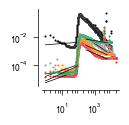

In [5]:
# neuropixels
# horvath vivo (all layers)
# L1 (probe 1)
psd_pre_hv1_L1 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L1["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]
# L23 (probe 1)
psd_pre_hv1_L23 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L23["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hv2_L4 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L4["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]
# L5 (probe 2)
psd_pre_hv2_L5 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L5["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_pre_hv3_L6 = copy.copy(psd_pre_hv3)
psd_pre_hv3_L6["power"] = psd_pre_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_pre_hv1_L1["power"],
        psd_pre_hv1_L23["power"],
        psd_pre_hv2_L4["power"],
        psd_pre_hv2_L5["power"],
        psd_pre_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_pre_hv1["freq"]


# horvath biophy. spont. (all layers) **************************
# L1 (probe 1)
psd_pre_hs1_L1 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L1["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_pre_hs1_L23 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L23["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hs2_L4 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L4["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_pre_hs2_L5 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L5["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_pre_hs3_L6 = copy.copy(psd_pre_hs3)
psd_pre_hs3_L6["power"] = psd_pre_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_pre_hs1_L1["power"],
        psd_pre_hs1_L23["power"],
        psd_pre_hs2_L4["power"],
        psd_pre_hs2_L5["power"],
        psd_pre_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_pre_hs1["freq"]


FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, prm["SFREQ_HV"], cl["COLOR_HV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_nv, alphas_spiking_nv = power.plot_fits_all(
    ax1, psd_pre_ms, prm["SFREQ_NV"], cl["COLOR_NV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_pre_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_pre_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, prm["SFREQ_HS"], cl["COLOR_HS"], pm, pm_fit1, pm_fit2
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_hv)
print_slope(alphas_lfp_nv)
print_slope(alphas_lfp_ns)
print_slope(alphas_lfp_ne)
print_slope(alphas_lfp_hs)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_hv)
print_slope(alphas_spiking_nv)
print_slope(alphas_spiking_ns)
print_slope(alphas_spiking_ne)
print_slope(alphas_spiking_hs)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_pre_nv["power"].shape[0]} sites""")
print(f"""n={psd_pre_ns["power"].shape[0]} sites""")
print(f"""n={psd_pre_ne["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")


# SNR **************************
print("\nPower SNR")

out_hv = power.get_power_snr(psd_all_hv["power"], psd_all_hv["freq"], 300, 6000, 90)
out_nv = power.get_power_snr(psd_pre_nv["power"], psd_pre_nv["freq"], 300, 6000, 90)
out_ns = power.get_power_snr(psd_pre_ns["power"], psd_pre_ns["freq"], 300, 6000, 90)
out_ne = power.get_power_snr(psd_pre_ne["power"], psd_pre_ne["freq"], 300, 6000, 90)
out_hs = power.get_power_snr(psd_all_hs["power"], psd_all_hs["freq"], 300, 6000, 90)
out_nb = power.get_power_snr(psd_pre_nb["power"], psd_pre_nb["freq"], 300, 6000, 90)

# # save
# if SAVE_FIG:
#     plt.savefig(
#         "figures/6_supp/fig2/fig2G_pre_power_fit_all_sites.svg",
#         **savefig_cfg,
#     )


LFP band
α=0.1±0.3
α=0.1±0.1
α=0.4±0.1
α=0.4±0.2
α=0.5±0.2

Spiking band
α=-1.4±0.3
α=-0.8±0.4
α=-0.5±0.4
α=-0.5±0.4
α=-0.2±0.2


n=272 sites
n=226 sites
n=202 sites
n=202 sites
n=297 sites

Power SNR
SNR: 2.47074031829834
SNR: 57.34489440917969
SNR: 10.211959838867188
SNR: 3.3656396865844727
SNR: 32.42094421386719
SNR: 66.31211853027344


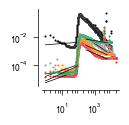

In [10]:
# horvath vivo (all layers)
# L1 (probe 1)
psd_pre_hv1_L1 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L1["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]
# L23 (probe 1)
psd_pre_hv1_L23 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L23["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hv2_L4 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L4["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]
# L5 (probe 2)
psd_pre_hv2_L5 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L5["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_pre_hv3_L6 = copy.copy(psd_pre_hv3)
psd_pre_hv3_L6["power"] = psd_pre_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_pre_hv1_L1["power"],
        psd_pre_hv1_L23["power"],
        psd_pre_hv2_L4["power"],
        psd_pre_hv2_L5["power"],
        psd_pre_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_pre_hv1["freq"]


# horvath biophy. spont. (all layers) **************************
# L1 (probe 1)
psd_pre_hs1_L1 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L1["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_pre_hs1_L23 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L23["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hs2_L4 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L4["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_pre_hs2_L5 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L5["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_pre_hs3_L6 = copy.copy(psd_pre_hs3)
psd_pre_hs3_L6["power"] = psd_pre_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_pre_hs1_L1["power"],
        psd_pre_hs1_L23["power"],
        psd_pre_hs2_L4["power"],
        psd_pre_hs2_L5["power"],
        psd_pre_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_pre_hs1["freq"]


FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, prm["SFREQ_HV"], cl["COLOR_HV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ms, alphas_spiking_ms = power.plot_fits_all(
    ax1, psd_pre_ms, prm["SFREQ_NV"], cl["COLOR_NV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_pre_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_pre_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, prm["SFREQ_HS"], cl["COLOR_HS"], pm, pm_fit1, pm_fit2
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_hv)
print_slope(alphas_lfp_ms)
print_slope(alphas_lfp_ns)
print_slope(alphas_lfp_ne)
print_slope(alphas_lfp_hs)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_hv)
print_slope(alphas_spiking_ms)
print_slope(alphas_spiking_ns)
print_slope(alphas_spiking_ne)
print_slope(alphas_spiking_hs)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_pre_ms["power"].shape[0]} sites""")
print(f"""n={psd_pre_ns["power"].shape[0]} sites""")
print(f"""n={psd_pre_ne["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")


# SNR **************************
print("\nPower SNR")

out_hv = power.get_power_snr(psd_all_hv["power"], psd_all_hv["freq"], 300, 6000, 90)
out_nv = power.get_power_snr(psd_pre_ms["power"], psd_pre_ms["freq"], 300, 6000, 90)
out_ns = power.get_power_snr(psd_pre_ns["power"], psd_pre_ns["freq"], 300, 6000, 90)
out_ne = power.get_power_snr(psd_pre_ne["power"], psd_pre_ne["freq"], 300, 6000, 90)
out_hs = power.get_power_snr(psd_all_hs["power"], psd_all_hs["freq"], 300, 6000, 90)
out_nb = power.get_power_snr(psd_pre_nb["power"], psd_pre_nb["freq"], 300, 6000, 90)

# # save
# if SAVE_FIG:
#     plt.savefig(
#         "figures/6_supp/fig2/fig2G_pre_power_fit_all_sites.svg",
#         **savefig_cfg,
#     )

## Compute data

In [6]:
d1 = power.get_psd_data_prepro(
    "L1",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d23 = power.get_psd_data_prepro(
    "L2_3",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d4 = power.get_psd_data_prepro(
    "L4",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)
d5 = power.get_psd_data_prepro_layer_5(
    "L5",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    psd_pre_nb,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d6 = power.get_psd_data_prepro(
    "L6",
    psd_pre_hv3,  # probe 3
    psd_pre_hs3,
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv3[sites_hv3],  # probe 3
    site_ly_hs3[sites_hs3],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

## Power law fits

cutoff 300  Hz


LFP band
hv: α=0.3±0.1
nv: α=0.1±0.1
ns: α=0.3±0.0
ne: α=0.2±0.0
hs: α=0.5±0.0

Spiking band
hv: α=-1.0±0.1
nv: α=-0.6±0.1
ns: α=-0.3±0.0
ne: α=-0.2±0.0
hs: α=-0.1±0.0

LFP band
hv: α=0.5±0.1
nv: α=0.0±0.1
ns: α=0.4±0.0
ne: α=0.3±0.2
hs: α=0.5±0.1

Spiking band
hv: α=-1.4±0.2
nv: α=-0.5±0.1
ns: α=-0.2±0.0
ne: α=-0.2±0.1
hs: α=-0.1±0.1

LFP band
hv: α=-0.1±0.0
nv: α=0.0±0.1
ns: α=0.5±0.0
ne: α=0.5±0.1
hs: α=0.5±0.1

Spiking band
hv: α=-1.5±0.1
nv: α=-0.4±0.1
ns: α=-0.6±0.1
ne: α=-0.6±0.1
hs: α=-0.2±0.1

LFP band
α=-0.2±0.1
α=0.1±0.1
α=0.6±0.1
α=0.6±0.2
α=0.5±0.1
α=0.4±0.3

Spiking band
α=-1.5±0.2
α=-0.7±0.2
α=-0.8±0.1
α=-0.8±0.2
α=-0.2±0.1
α=-0.5±0.5

Power SNR
SNR: 2.2521305084228516
SNR: 45.80379104614258
SNR: 8.467751502990723
SNR: 2.9833710193634033
SNR: 43.673789978027344
SNR: 11.646443367004395

LFP band
hv: α=-0.0±0.2
nv: α=0.1±0.1
ns: α=0.3±0.0
ne: α=0.3±0.2
hs: α=0.6±0.2

Spiking band
hv: α=-1.3±0.2
nv: α=-0.9±0.4
ns: α=-0.3±0.1
ne: α=-0.3±0.2
hs: α=-0.3±0.3


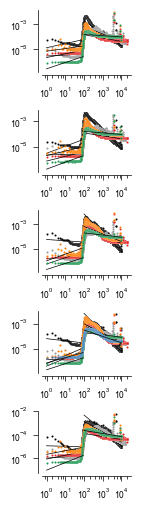

In [13]:
# cutoff 100 Hz
FIG_SIZE = (1.3, 5)

fig, axes = plt.subplots(5, 1, figsize=FIG_SIZE)

# L1
axes[0], dd1 = power.plot_power_law_fits(axes[0], d1, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L2/3
axes[1], dd23 = power.plot_power_law_fits(axes[1], d23, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L4
axes[2], dd4 = power.plot_power_law_fits(axes[2], d4, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L5
axes[3], dd5 = power.plot_power_law_fits_layer_5(
    axes[3], d5, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000)
)
# L6
axes[4], dd6 = power.plot_power_law_fits(axes[4], d6, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))

fig.tight_layout(**tight_layout_cfg)

# save
if SAVE_FIG: plt.savefig("figures/0_validation/4_power/fig2R/supp_figa_prepro_power_fit.svg", **savefig_cfg)

# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
